Import libraries and Get Weather Station Info available from Met Eireann. 

In [217]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
import requests
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import numpy as np
from sklearn.neighbors import BallTree
from zipfile import ZipFile
import os

#Get Weather Stations details available from Met Eireann 
wsdf = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv')
wsdf.head
print(wsdf.dtypes)

county           object
station name      int64
name             object
height(m)         int64
easting           int64
northing          int64
latitude        float64
longitude       float64
open year        object
close year       object
dtype: object


The Values in 'open year' and 'close year' are a combination of numeric text values and '(null)'
We want to analyse data from Weather Stations which have data from 2010 to the present
We'll convert the '(null)' to a future year '300' and convert to int.
This allows us to filter the data based on Year

In [218]:
#Convert Values in 'open year' and 'close year' from '(null)' to future year '3000'
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].replace(['(null)'], '3000')
#Change 'open year' and 'close year' to int
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].astype(int)
print(wsdf.dtypes)
#Filter Weather Stations to those reporting data from 2013 to the present
ltywsdf=wsdf.loc[(wsdf['close year'] == 3000) & (wsdf['open year'] < 2015)]
ltywsdf.head

county           object
station name      int64
name             object
height(m)         int64
easting           int64
northing          int64
latitude        float64
longitude       float64
open year         int32
close year        int32
dtype: object


<bound method NDFrame.head of        county  station name                             name  height(m)  \
0      Antrim          5880                  LH_RATHLIN_WEST         10   
1      Carlow          4415              TULLOW (Waterworks)         76   
10     Carlow          6114             POLLMOUNTY FISH FARM         24   
15     Carlow           375                         OAK PARK         62   
17     Carlow          4515           TULLOW (Ardoyne Glebe)         79   
...       ...           ...                              ...        ...   
2074  Wicklow          9420  M.GLENMALURE (Cloghernagh For.)        436   
2075  Wicklow          9520   M.RATHDRUM (Ballintombay For.)        384   
2078  Wicklow          9820                    M.LOUGH OULER        457   
2079  Wicklow          2415            GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420              OLDBRIDGE (Oakview)        335   

      easting  northing  latitude  longitude  open year  close year  

Verify the stations have a satisfactory geographical distribution by plotting the latitude and longitude

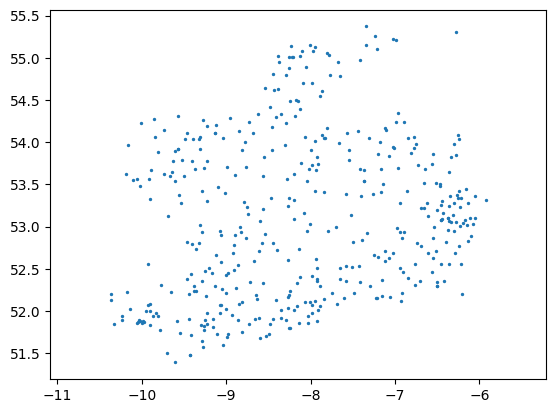

In [219]:
plt.scatter(x=ltywsdf['longitude'],y=ltywsdf['latitude'],s=2)
plt.axis('equal')

plt.show()


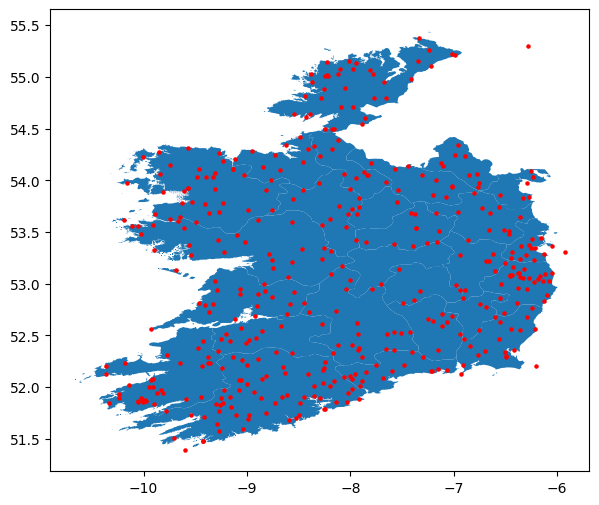

In [220]:
IRL_map= gpd.read_file('./IRL_adm/IRL_adm1.shp')  #reading the map 
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);

Remove Rathlin Island Station from dataframe as it is not in scope here

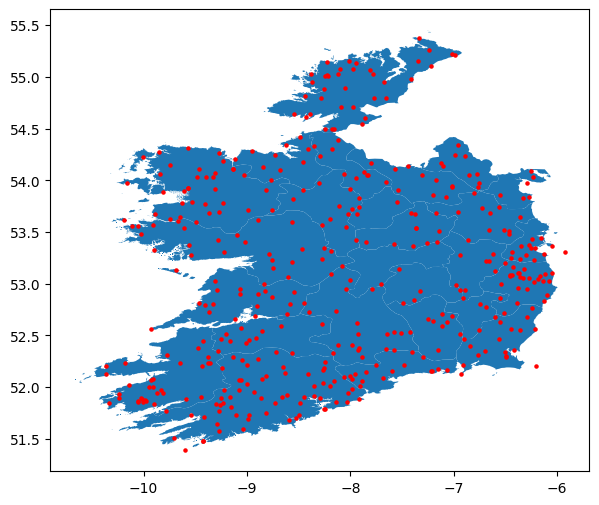

In [221]:
ltywsdf = ltywsdf.loc[ltywsdf["name"] != 'LH_RATHLIN_WEST']
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);

Check if hourly data exists for the stations, if not drop it from the stations dataset, otherwise download and unzip the hourly data for the station

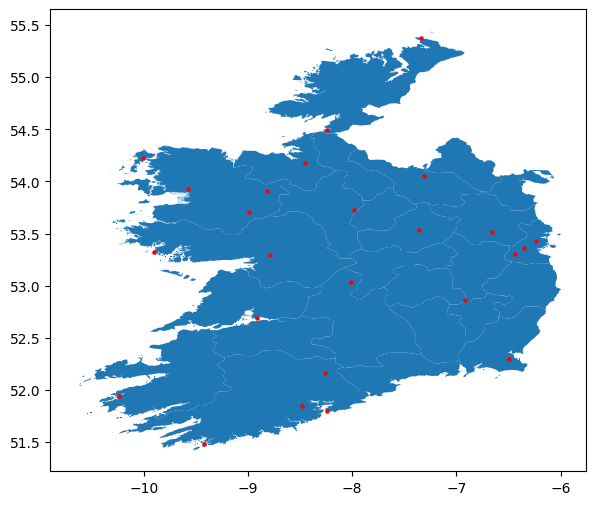

In [14]:
def url_checker(url):
	try:
		#Get Url
		get = requests.get(url)
		# if the request succeeds 
		if get.status_code == 200:
			return True
		else:
			return False
	#Exception
	except requests.exceptions.RequestException as e:
        # print URL with Errs
		return False

baseurl='https://cli.fusio.net/cli/climate_data/webdata/hly'
basezipfile='./weatherstationdata/zipped/hly'
baseunzipfile=basezipfile.replace("zipped", "unzipped")
for station in ltywsdf['station name']:
    stationurl=baseurl+str(station)+'.zip'
    stationzipfile=basezipfile+str(station)+'.zip'
    stationzipfolder=stationzipfile[:-4]
    stationunzipfolder=stationzipfolder.replace("zipped", "unzipped")
    if url_checker(stationurl):
        response = requests.get(stationurl)
        open(stationzipfile, "wb").write(response.content)
        with ZipFile(stationzipfile, 'r') as zip_ref:
                zip_ref.extractall(stationunzipfolder)
    else:
        ltywsdf = ltywsdf.loc[ltywsdf["station name"] != station]
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);	


Unzip


Get Distance between nearest neighbours

In [261]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree



import numpy as np
from sklearn.neighbors import BallTree

arcltywsdf=ltywsdf

ltywsdf.head
# the formula requires rad instead of degree
ltywsdf[["lat_rad", "lon_rad"]] = np.deg2rad(ltywsdf[["latitude", "longitude"]])

ball_tree = BallTree(ltywsdf[["lat_rad", "lon_rad"]], metric="haversine")

distances,neighbors = ball_tree.query(
    ltywsdf[["lat_rad", "lon_rad"]],
    k=2,  # k + 1 because we remove the address itself later, hence we need k - 1 = k_desired
    return_distance=True,  # choose whether you also want to return the distance
    sort_results=True,
)

# remove the address/point itself from the array because it itself is its nearest neighbour
neighbors = neighbors[:, 1:]
#print(neighbors)
distances = distances[:, 1:]

ltywsdf["nearest_stations"] = [
    ltywsdf["name"].iloc[n].to_list() for n in neighbors
]
ltywsdf["nearest_station_distance(rad)"] = distances
ltywsdf["nearest_station_distance(km)"] = distances*6371


ltywsdf.explode("nearest_stations")[["name", "nearest_stations"]]
#ltywsdf.explode("nearest_station_distance")[["name", "nearest_station_distance"]]
ltywsdf.head
ltywsdf.to_csv('./weatherstationdata/stationinfo.csv')

Plot a distribution of the Nearest Neighbour distances

<Axes: ylabel='Density'>

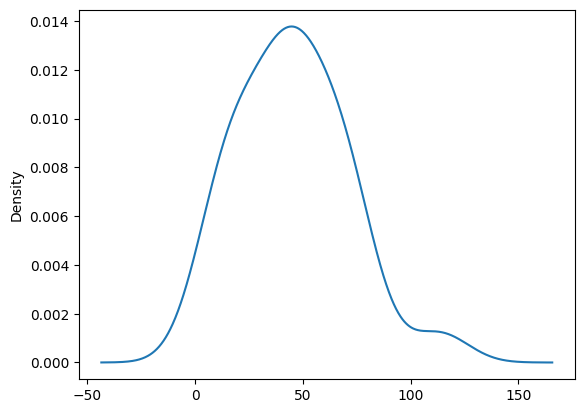

In [16]:
#ltywsdf.to_csv('C:/scripts/stationsdistance.csv')
ltywsdf["nearest_station_distance(km)"].plot(kind='kde')
#ltywsdf.describe()

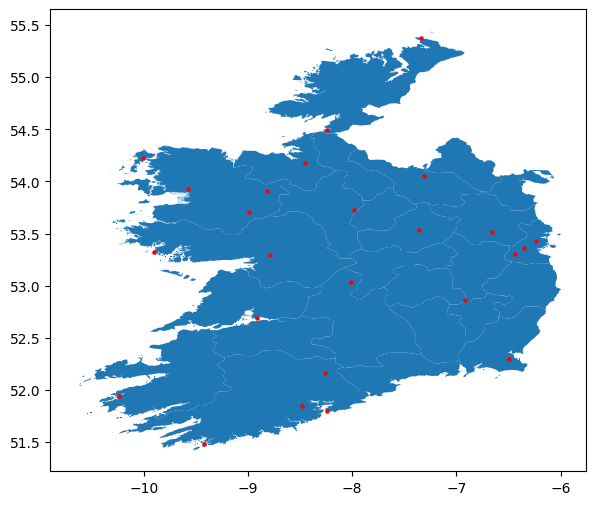

In [17]:
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);	

For each file in ./weatherstationdata/unzipped unzip the archive
with file hly*.csv 
Find  'date:' and for each line until blank line create a dictionary
Find column headers starting with date, and read the rest of the file into dataframe
Rename the columns as per the dictionary
Delete unused columns

In [232]:

import os
wdict={}
stationunziphomefolder = basezipfile[:-4].replace('zipped','unzipped')
for folder in os.listdir(stationunziphomefolder):
    weatherdatafile=stationunziphomefolder+'/'+folder+"/"+folder+'.csv'
    #print(weatherdatafile)
    inblock=False
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
            if 'date:' in line or (inblock and line.strip()):
                inblock=True
                wdict[line.split(":")[0]] = line.split("-")[1].strip()
            else:
                if inblock:
                    break
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
                if 'date,' in line:
                    firstline = lineno
                    break 
    if (',wdsp' in line): 
        with open(weatherdatafile, 'r') as wf:
            for lineno, line in enumerate(wf):    
                lines=wf.readlines()   
        # Write file
        stationprochomefolder=stationunziphomefolder.replace('unzipped','processed')
        weatherdataprocfile=stationprochomefolder+"/"+weatherdatafile.split("/")[-1]
        with open(weatherdataprocfile, 'w') as wwf:
            # iterate each line
            for lineno, line in enumerate(lines):
                if lineno > (firstline-2):
                    wwf.write(line)
    else:
        print("Not Processing : "+folder)
        stationname=int(folder[3:])
        ltywsdf = ltywsdf.loc[ltywsdf["station name"] != stationname]
ltywsdf.shape
ltywsdf.head

Not Processing : hly1275
Not Processing : hly175


<bound method NDFrame.head of        county  station name                             name  height(m)  \
1      Carlow          4415              TULLOW (Waterworks)         76   
10     Carlow          6114             POLLMOUNTY FISH FARM         24   
15     Carlow           375                         OAK PARK         62   
17     Carlow          4515           TULLOW (Ardoyne Glebe)         79   
25     Carlow          2115           HACKETSTOWN (Voc.Sch.)        189   
...       ...           ...                              ...        ...   
2074  Wicklow          9420  M.GLENMALURE (Cloghernagh For.)        436   
2075  Wicklow          9520   M.RATHDRUM (Ballintombay For.)        384   
2078  Wicklow          9820                    M.LOUGH OULER        457   
2079  Wicklow          2415            GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420              OLDBRIDGE (Oakview)        335   

      easting  northing  latitude  longitude  open year  close year  

In [260]:
ltywsdf.head

<bound method NDFrame.head of        county  station name                             name  height(m)  \
1      Carlow          4415              TULLOW (Waterworks)         76   
10     Carlow          6114             POLLMOUNTY FISH FARM         24   
15     Carlow           375                         OAK PARK         62   
17     Carlow          4515           TULLOW (Ardoyne Glebe)         79   
25     Carlow          2115           HACKETSTOWN (Voc.Sch.)        189   
...       ...           ...                              ...        ...   
2074  Wicklow          9420  M.GLENMALURE (Cloghernagh For.)        436   
2075  Wicklow          9520   M.RATHDRUM (Ballintombay For.)        384   
2078  Wicklow          9820                    M.LOUGH OULER        457   
2079  Wicklow          2415            GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420              OLDBRIDGE (Oakview)        335   

      easting  northing  latitude  longitude  open year  close year  

In [ ]:
#print(stationprochomefolder)
allwddf=pd. DataFrame()
startdate=pd.to_datetime('2014-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
for file in os.listdir(stationprochomefolder):
    weatherdataprocfile=stationprochomefolder+"/"+file
    print(weatherdataprocfile)
    wddf = pd.read_csv(weatherdataprocfile)
    wddf['Datetime'] = pd.to_datetime(wddf['date'], format='%d-%b-%Y %H:%M')
    mask = (wddf['Datetime']  >= startdate) & (wddf['Datetime'] < enddate)
    wddf = wddf.loc[mask]
    columns = list(wddf.columns.values)
    retaincolumns=["Datetime","wdsp"]
    wddf = wddf.loc[:, retaincolumns]
    wddf['station name'] = int(file[3:][:-4])
    #Quick and Dirty Data Cleansing
    wddf['wdsp'] = wddf['wdsp'].replace(' ','0')
    wddf['wdsp'] = wddf['wdsp'].astype(int)
    allwddf=pd.concat([allwddf, wddf], axis=0,ignore_index=True)
    #break
allwddf.shape

In [254]:
allwddf.head
allwddf.reset_index(drop=True)
allwddf = allwddf.set_index(pd.DatetimeIndex(allwddf['Datetime']))
pivwddf=allwddf.pivot(index="Datetime", columns="station name", values="wdsp")
pivwddf.to_csv('./weatherstationdata/wspivot.csv')
#pivwddf["Datetime"].max()-pivwddf["Datetime"].min()

##wgalldf.reset_index(drop=True) #
#wgalldf['Datetime'] = pd.to_datetime(wgalldf['Datetime'])
#wgalldf = wgalldf.drop(columns=['DATE & TIME', 'FORECAST WIND(MW)','REGION'])
#cols = wgalldf.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#wgalldf = wgalldf[cols]
#wgalldf = wgalldf.set_index(pd.DatetimeIndex(wgalldf['Datetime']))


In [256]:
pivwddf.dtypes
#allwddf.groupby(allwddf["Datetime"].dt.month)["wdsp"].max().plot(
#    kind='bar', rot=0
#)
#pivwddf['Datetime'].max()-pivwddf['Datetime'].min()
#pivwddf["Datetime"].max()

station name
275     int32
375     int32
518     int32
532     int32
575     int32
675     int32
775     int32
875     int32
1075    int32
1175    int32
1375    int32
1475    int32
1575    int32
1775    int32
1875    int32
1975    int32
2075    int32
2175    int32
2275    int32
2375    int32
3723    int32
3904    int32
4935    int32
dtype: object

<Axes: xlabel='Datetime'>

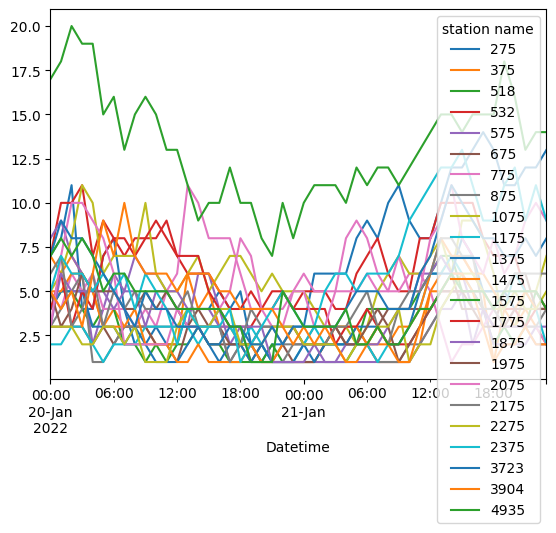

In [259]:
pivwddf["2022-01-20":"2022-01-21"].plot()

##  Need to do some replacements here  ##
For now, putting 0 in place
Fixing for missing data

In [228]:
for k, v in wddf[wddf['wddir'] == ' '].groupby((wddf['wddir'] != ' ').cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v.count())
    print('\n')



[group 2639]
2014-04-20 23:00:00
2014-04-20 23:00:00
Datetime        1
wddir           1
station name    1
dtype: int64


[group 11549]
2015-04-27 06:00:00
2015-04-27 06:00:00
Datetime        1
wddir           1
station name    1
dtype: int64


[group 11600]
2015-04-29 10:00:00
2015-04-29 14:00:00
Datetime        5
wddir           5
station name    5
dtype: int64


[group 11603]
2015-04-29 18:00:00
2015-04-29 20:00:00
Datetime        3
wddir           3
station name    3
dtype: int64




## Don't use this, keeping for reference ##
For each file in the processed folder,Remove historical data prior to 2014
##

In [20]:
print(stationprochomefolder)
allwddf=pd. DataFrame()
startdate=pd.to_datetime('2014-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
for file in os.listdir(stationprochomefolder):
    weatherdataprocfile=stationprochomefolder+"/"+file
    print(weatherdataprocfile)
    wddf = pd.read_csv(weatherdataprocfile)
    wddf['datetime'] = pd.to_datetime(wddf['date'], format='%d-%b-%Y %H:%M')
    wddf.head
    mask = (wddf['datetime']  >= startdate) & (wddf['datetime'] < enddate)
    wddf = wddf.loc[mask]
    columns = list(wddf.columns.values) 
    #for column in columns[::-1]:
    #    print(column)
    #retaincolumns=["datetime"]
    #wantedcolumns=["wdsp","wddir","sun"]
    for col in columns:
#        if col in wddf.columns:
#        retaincolumns.append(col)
        colloc=wddf.columns.get_loc(col)
#        print(colloc)
        if (wddf.columns[colloc-1].startswith('ind')):
            wddf.rename(columns={wddf.columns[colloc-1]: 'ind'+col}, inplace=True)
                #retaincolumns.append(wddf.columns[colloc-1])
#        else:
#            print(col+" not found")
#    print(retaincolumns)
#    wddf = wddf.loc[:, retaincolumns]
    wddf['station name'] = file[3:][:-4]

    break
#weatherdatafilename=weatherdatafile.split("/")[-1]
#print(weatherdatafilename)
##stationunprochomefolder=stationunziphomefolder.replace('unzipped','processed')
#print(stationunprochomefolder)
#foreach 
#wddf = pd.read_csv(weatherdatafile)
#wddf.columns = wddf.columns.to_series().map(wdict)
wddf.head    

./weatherstationdata/processed
./weatherstationdata/processed/hly1075.csv


C:\Users\czl\AppData\Local\Temp\ipykernel_2920\1627422374.py:8: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)


<bound method NDFrame.head of                      date  indrain rain  indtemp temp  indwetb wetb dewpt  \
481102  01-jan-2013 00:00        0  0.0        0  5.1        0  3.9   2.2   
481103  01-jan-2013 01:00        0  0.0        0  4.8        0  3.7   1.9   
481104  01-jan-2013 02:00        0  0.1        0  5.0        0  3.9   2.2   
481105  01-jan-2013 03:00        0  0.0        0  4.8        0  4.0   2.7   
481106  01-jan-2013 04:00        0  0.0        0  4.1        0  3.4   2.4   
...                   ...      ...  ...      ...  ...      ...  ...   ...   
568745  31-dec-2022 19:00        0  1.0        0  8.3        0  7.7   7.0   
568746  31-dec-2022 20:00        0  2.7        0  8.0        0  7.3   6.5   
568747  31-dec-2022 21:00        0  0.5        0  7.2        0  6.5   5.6   
568748  31-dec-2022 22:00        0  0.5        0  7.1        0  6.3   5.3   
568749  31-dec-2022 23:00        0  0.5        0  7.0        0  6.3   5.5   

       vappr rhum     msl  indwdsp wdsp  indw

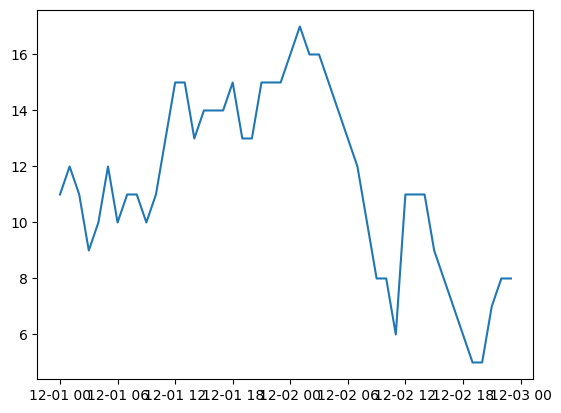

In [21]:
#plt.plot(wddf['datetime'], wddf['wsdf'])
wddf.head
startdate=pd.to_datetime('2022-12-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2022-12-03', format='%Y-%m-%d')
mask = (wddf['datetime']  >= startdate) & (wddf['datetime'] < enddate)
sample = wddf.loc[mask]
sample.head
#sampledate='2022-12-31'
#sample=wddf.loc[wddf['datetime']==sampledate]
plt.plot(sample['datetime'], sample['wdsp'])
#sample.head

##  No Need to rerun - Download Job  ##
Get the Actual Electricity Demand from https://www.smartgriddashboard.com/DashboardService.svc
Last 3o days data available by using this url.
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=demandActual&region=ALL&datefrom=04-Feb-2023%2000:00&dateto=05-Mar-2023%2023:59

Crafting urls by manipulating the url parameters allows the possibility of downloading data for custom timeframes.
Attempting to download a full year resulted in an empty file
It was possible to download data in monthly chunks like so
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=generationActual&region=ROI&datefrom=01-Dec-2022%2000:00&dateto=31-Dec-2022%2023:59
Use the calendar and datetime libraries to get the first and last days of each month from 2013 to 2022 and inject these into the url to download the data

In [ ]:
import calendar
from datetime import datetime

baseurl="https://www.smartgriddashboard.com/DashboardService.svc/csv?area=demandActual&region=ROI&datefrom="
separator="%2000:00&dateto="
end="%2023:59"
edfolder="./electricitydemand/monthly/"
edfileprefix='ElectricityDemandROIMonthly'
edfileextension='.csv'

for year in range(2013,2023):
    for month in range(1, 13):
        #print(month)
        input_dt = datetime(year, month, 1)
        datefrom=input_dt.strftime('%d-%b-%Y')
        res = calendar.monthrange(input_dt.year, input_dt.month)
        day = res[1]
        last_dt = datetime(year, month, day)
        dateto = last_dt.strftime('%d-%b-%Y')
        #print(dateto)
        monthto=last_dt.strftime('%Y%m')
        url=baseurl+datefrom+separator+dateto+end
        edfile=edfolder+edfileprefix+monthto+edfileextension
        print(url)
        print(edfile)
        if url_checker(url):
            response = requests.get(url)
            #print(response.content)
            open(edfile, "wb").write(response.content)    


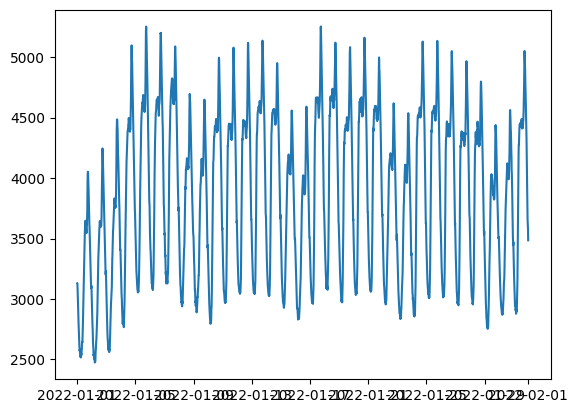

In [6]:
file="./electricitydemand/monthly/ElectricityDemandROIMonthly202201.csv"
demdf=pd.read_csv(file)

demdf['datetime'] = pd.to_datetime(demdf['DATE & TIME'], format='%d %B %Y %H:%M')

#demdf.rename(columns={wddf.columns[colloc-1]: 'ind'+col}, inplace=True)
#plt.plot(demdf['datetime'], sample['ACTUAL GENERATION(MW)'])

columns = list(demdf.columns.values) 
demdf.columns = demdf.columns.str.strip()
demdf.dtypes
plt.plot(demdf['datetime'], demdf['ACTUAL DEMAND(MW)'])

##  No Need to rerun - Download Job  ##
Download WindGeneration

In [ ]:
import calendar
from datetime import datetime

baseurl="https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom="
separator="%2000:00&dateto="
end="%2023:59"
edfolder="./windgeneration/monthly/"
edfileprefix='WindGenerationROIMonthly'
edfileextension='.csv'

for year in range(2013,2023):
    for month in range(1, 13):
        #print(month)
        input_dt = datetime(year, month, 1)
        datefrom=input_dt.strftime('%d-%b-%Y')
        res = calendar.monthrange(input_dt.year, input_dt.month)
        day = res[1]
        last_dt = datetime(year, month, day)
        dateto = last_dt.strftime('%d-%b-%Y')
        #print(dateto)
        monthto=last_dt.strftime('%Y%m')
        url=baseurl+datefrom+separator+dateto+end
        edfile=edfolder+edfileprefix+monthto+edfileextension
        print(url)
        print(edfile)
        if url_checker(url):
            response = requests.get(url)
            #print(response.content)
            open(edfile, "wb").write(response.content)    


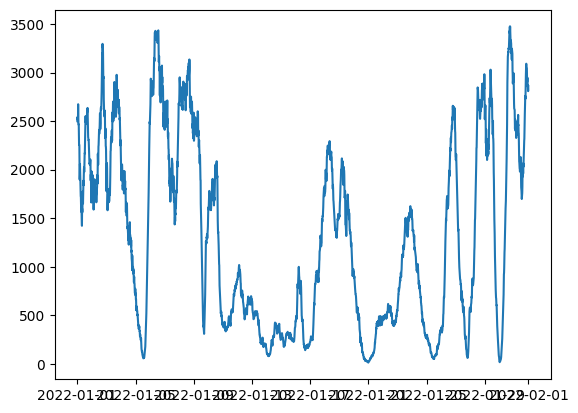

In [23]:
file="./windgeneration/monthly/WindGenerationROIMonthly202201.csv"
wgdf=pd.read_csv(file)

wgdf['datetime'] = pd.to_datetime(wgdf['DATE & TIME'], format='%d %B %Y %H:%M')
columns = list(wgdf.columns.values) 
wgdf.columns = wgdf.columns.str.strip()
wgdf.dtypes
plt.plot(wgdf['datetime'], wgdf['ACTUAL WIND(MW)'])

##  No Need to rerun - Processing Job  ##
Process the files and merge into Single Dataframe, write to file ./windgeneration/processed/WindGenerationROIAll.csv

In [262]:
wgalldf=pd.DataFrame()
wgfolder="./windgeneration/monthly/"
wgfileprefix='WindGenerationROIMonthly'
wgfileextension='.csv'
wgprocessedfolder="./windgeneration/processed/"
wgprocessedfile='WindGenerationROIAll.csv'
for file in os.listdir(wgfolder):
    wgfile=wgfolder+file
    #print(wgfile)
    wgdf=pd.read_csv(wgfile)
    wgalldf=pd.concat([wgalldf, wgdf], axis=0,ignore_index=True)

columns = list(wgalldf.columns.values) 
wgalldf.columns = wgalldf.columns.str.strip()
wgalldf.drop_duplicates(subset=['DATE & TIME', 'ACTUAL WIND(MW)'],inplace = True)
wgalldf['Datetime'] = pd.to_datetime(wgalldf['DATE & TIME'], format='%d %B %Y %H:%M')

wgalldf.reset_index(drop=True) #
wgalldf['Datetime'] = pd.to_datetime(wgalldf['Datetime'])
wgalldf = wgalldf.drop(columns=['DATE & TIME', 'FORECAST WIND(MW)','REGION'])
cols = wgalldf.columns.tolist()
cols = cols[-1:] + cols[:-1]
wgalldf = wgalldf[cols]
wgalldf = wgalldf.set_index(pd.DatetimeIndex(wgalldf['Datetime']))
#Replace invalid values with '0'
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].replace('-','0')
#Convert 'ACTUAL WIND(MW)' to int
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].astype('int')
#Replace negative values with positive counterparts, seems to be a data entry error after visual inspection
wgalldf['ACTUAL WIND(MW)'] = np.where(wgalldf['ACTUAL WIND(MW)'] < 0,
                                      wgalldf['ACTUAL WIND(MW)'] * -1,
                                      wgalldf['ACTUAL WIND(MW)'])
#Reduce Sample Size from Quarter Hourly to hourly, use the mean for the hour as the new value
wgalldf = wgalldf.resample("H").max()

wgalldf.to_csv('./windgeneration/windgen2014-2022.csv')
wgalldf.head
#[78888 rows x 2 columns]>
#wgalldf.dtypes

<bound method NDFrame.head of                                Datetime  ACTUAL WIND(MW)
Datetime                                                
2014-01-01 00:00:00 2014-01-01 00:45:00             1020
2014-01-01 01:00:00 2014-01-01 01:45:00              931
2014-01-01 02:00:00 2014-01-01 02:45:00              947
2014-01-01 03:00:00 2014-01-01 03:45:00              929
2014-01-01 04:00:00 2014-01-01 04:45:00              951
...                                 ...              ...
2022-12-31 19:00:00 2022-12-31 19:45:00              443
2022-12-31 20:00:00 2022-12-31 20:45:00              611
2022-12-31 21:00:00 2022-12-31 21:45:00              539
2022-12-31 22:00:00 2022-12-31 22:45:00              540
2022-12-31 23:00:00 2022-12-31 23:45:00              571

[78888 rows x 2 columns]>

Merge the Wind Speed and Windgeneration data

In [308]:
windall = pivwddf.join(wgalldf, how='outer')
#windall.to_csv('./windgeneration/windall.csv')
windall.drop('Datetime', axis=1, inplace=True)
windall.dtypes


275                int32
375                int32
518                int32
532                int32
575                int32
675                int32
775                int32
875                int32
1075               int32
1175               int32
1375               int32
1475               int32
1575               int32
1775               int32
1875               int32
1975               int32
2075               int32
2175               int32
2275               int32
2375               int32
3723               int32
3904               int32
4935               int32
ACTUAL WIND(MW)    int32
dtype: object

In [288]:
inputparams=windall.columns.values.tolist()
inputparams=inputparams[:-1]
#print(inputparams)
startdate=pd.to_datetime('2022-12-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-31', format='%Y-%m-%d')
mask = (windall.index  >= startdate) & (windall.index < enddate)
sample = windall.loc[mask]
#sample.reset_index(drop=True)
#sample = sample.set_index(pd.DatetimeIndex(sample['Datetime']))
#sample.drop('Datetime', axis=1, inplace=True)

sample.head

<bound method NDFrame.head of                      275  375  518  532  575  675  775  875  1075  1175  ...  \
Datetime                                                                 ...   
2022-12-01 00:00:00   10    7    7    1    5    5   11    6    11     4  ...   
2022-12-01 01:00:00   11    4    9    3    5    5   13    5    12     3  ...   
2022-12-01 02:00:00   10    4    7    3    4    5   13    4    11     5  ...   
2022-12-01 03:00:00    9    5    7    3    4    5   11    3     9     5  ...   
2022-12-01 04:00:00   11    3    6    3    3    6    8    4    10     5  ...   
...                  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
2022-12-31 19:00:00    5    4    4    2    3    3    9    2     5     3  ...   
2022-12-31 20:00:00    5    2    2    2    3    2   18    2    16     2  ...   
2022-12-31 21:00:00    4    6    2    3    5    2   15    2    15     3  ...   
2022-12-31 22:00:00    4    9    2    4    5    2   15    1    15     4  ...   
2022-12-31

Liner regression
Random samples 
Model : Linear regression, Expected : 1027,Predicted Value: [901.3490471]
Model : Random Forest Regression, Expected : 1027,Predicted Value: [911.69]
Model : Linear regression, Expected : 382,Predicted Value: [277.42348934]
Model : Random Forest Regression, Expected : 382,Predicted Value: [346.79]



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#Set the Input variables
import numpy as np

windall = pivwddf.join(wgalldf, how='outer')
#windall.to_csv('./windgeneration/windall.csv')
windall.drop('Datetime', axis=1, inplace=True)


inputparams=windall.columns.values.tolist()
inputparams=inputparams[:-1]
#print(count(inputparams))
#Use Entire Dataset
startdate=pd.to_datetime('2014-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
mask = (windall.index  >= startdate) & (windall.index < enddate)
sample = windall.loc[mask]

X = sample[inputparams]
y = sample['ACTUAL WIND(MW)'].values

regr = LinearRegression()
regr.fit(X, y)

regrf = RandomForestRegressor()
regrf.fit(X, y)

resdf = pd.DataFrame(columns=['Model', 'Year', 'Expected','Predicted'])

for year in range(2014,2023):
    inputquery="index == '"+str(year)+"-12-16 00:00:00' "
    #print(inputquery)
    inputlist=sample.query(inputquery)[inputparams].values.tolist()
    #print(listy)
    expected=sample.query(inputquery)['ACTUAL WIND(MW)'].values[0]
    #print(expected)
    model='Linear regression'
    predictedWindMW = regr.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMW[0]))
    data = [[model, year,expected,predictedWindMW[0]]]
    resdf = resdf.append(data, ignore_index=True)

    model='Random Forest regression'
    predictedWindMWf = regrf.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMWf[0]))
    data = [[model, year,expected,predictedWindMWf[0]]]
    resdf = resdf.append(data, ignore_index=True)
  
# Output the results DataFrame
resdf.to_csv('./modeltests/testresults.csv')

#Tests - 9 Years of Data sampling from 2014-2022 on 16th December
#array of lists
""" (16,3,3,12,1,7,3,3,6,8,7,5,21,7,4,6,15,6,3,10,10,6,8)
(16,3,3,12,1,7,3,3,6,8,7,5,21,7,4,6,15,6,3,10,10,6,8)
(5,9,5,9,10,3,5,3,23,1,7,5,8,14,4,6,5,2,7,5,5,20,3)
(7,4,3,11,4,3,8,3,12,3,4,4,11,3,2,5,4,5,3,6,9,11,7)
(24,13,10,12,5,12,21,9,11,11,14,10,29,10,7,10,18,8,11,17,16,4,10)
(12,14,9,13,9,5,15,7,20,8,12,14,10,19,9,3,2,7,8,8,18,12,7)
(17,13,15,15,17,7,26,10,32,11,10,16,16,21,10,10,11,11,16,9,15,29,12)
(15,4,5,6,3,3,10,3,12,7,7,4,12,7,4,2,9,8,8,15,9,6,10)
(2,2,3,8,3,1,6,1,10,2,3,3,12,8,1,1,5,1,4,6,6,9,5) """



""" # 2021-12-16 00:00:00,15,4,5,6,3,3,10,3,12,7,7,4,12,7,4,2,9,8,8,15,9,6,10,2021-12-16 00:45:00,1027
expected='1027'
#Linear regression
model='Linear regression'
predictedWindMW = regr.predict([[15,4,5,6,3,3,10,3,12,7,7,4,12,7,4,2,9,8,8,15,9,6,10]])
print('Model : '+model+", Expected : "+expected+",Predicted Value: "+str(predictedWindMW))

# 2021-12-16 00:00:00,15,4,5,6,3,3,10,3,12,7,7,4,12,7,4,2,9,8,8,15,9,6,10,2021-12-16 00:45:00,1027
#Random Forest Regression
model='Random Forest Regression'
predictedWindMWf = regrf.predict([[15,4,5,6,3,3,10,3,12,7,7,4,12,7,4,2,9,8,8,15,9,6,10]])
print('Model : '+model+", Expected : "+expected+",Predicted Value: "+str(predictedWindMWf))

# 2022-01-16 12:00:00,3,7,8,10,3,3,2,3,9,2,6,6,14,6,5,3,7,3,5,6,5,9,5,2022-01-16 12:45:00,382 
expected='382'
#Linear regression
model='Linear regression'
predictedWindMW = regr.predict([[3,7,8,10,3,3,2,3,9,2,6,6,14,6,5,3,7,3,5,6,5,9,5]])
print('Model : '+model+", Expected : "+expected+",Predicted Value: "+str(predictedWindMW))

# 2022-01-16 12:00:00,3,7,8,10,3,3,2,3,9,2,6,6,14,6,5,3,7,3,5,6,5,9,5,2022-01-16 12:45:00,382 
#Random Forest Regression
model='Random Forest Regression'
predictedWindMWf = regrf.predict([[3,7,8,10,3,3,2,3,9,2,6,6,14,6,5,3,7,3,5,6,5,9,5]])
print('Model : '+model+", Expected : "+expected+",Predicted Value: "+str(predictedWindMWf)) """

# extract the seasonality data
#months = [x.month for x in co2_data.index]
#years = [x.year for x in co2_data.index]
#day = [x.day for x in co2_data.index]

# convert into one matrix
#X = np.array([inputparams]).T

# fit the model
#my_lr = LinearRegression()
#my_lr.fit(inputparams, co2_data.co2.values)

# predict on the same period
#preds = regr.predict(X)

# plot what has been learned
#plt.plot(sample.index, sample['ACTUAL WIND(MW)'])
#plt.plot(sample.index, preds)

Addition of temporal parameters Y M D 

Model : Linear regression, Expected : 1027,Predicted Value: [1095.91047667]
Model : Random Forest Regression, Expected : 1027,Predicted Value: [1045.81]
Model : Linear regression, Expected : 382,Predicted Value: [589.66492998]
Model : Random Forest Regression, Expected : 382,Predicted Value: [388.71]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
#Set the Input variables
import numpy as np

windall = pivwddf.join(wgalldf, how='outer')
#windall.to_csv('./windgeneration/windall.csv')
windall.drop('Datetime', axis=1, inplace=True)

inputparams=windall.columns.values.tolist()
inputparams=inputparams[:-1]

#Adding Y M D as parameters
#windall[1]=windall.index.year.astype(int)
#windall[2]=windall.index.month.astype(int)
#windall[3]=windall.index.day.astype(int)
windall[1]=windall.index.year
windall[2]=windall.index.month
windall[3]=windall.index.day
inputparams+=(1,2,3)
print(inputparams)

#print(count(inputparams))
startdate=pd.to_datetime('2014-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
mask = (windall.index  >= startdate) & (windall.index < enddate)
sample = windall.loc[mask]

X = sample[inputparams]
y = sample['ACTUAL WIND(MW)'].values

regr = LinearRegression()
regr.fit(X, y)

regrf = RandomForestRegressor()
regrf.fit(X, y)

resdf = pd.DataFrame(columns=['Model', 'Year', 'Expected','Predicted'])

for year in range(2014,2023):
    inputquery="index == '"+str(year)+"-12-16 00:00:00' "
    #print(inputquery)
    inputlist=sample.query(inputquery)[inputparams].values.tolist()
    #print(listy)
    expected=sample.query(inputquery)['ACTUAL WIND(MW)'].values[0]
    #print(expected)
    model='Linear regression'
    predictedWindMW = regr.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMW[0]))
    data = [[model, year,expected,predictedWindMW[0]]]
    resdf = resdf.append(data, ignore_index=True)

    model='Random Forest regression'
    predictedWindMWf = regrf.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMWf[0]))
    data = [[model, year,expected,predictedWindMWf[0]]]
    resdf = resdf.append(data, ignore_index=True)
  
# Output the results DataFrame
resdf.to_csv('./modeltests/testresultsYMD.csv')


MeanSquared Error

The mean squared error (MSE) for Linear Regression on test set: 153447.4715
The mean squared error (MSE) for Forest Regression on test set: 12987.0796

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#Set the Input variables
import numpy as np

windall = pivwddf.join(wgalldf, how='outer')
#windall.to_csv('./windgeneration/windall.csv')
windall.drop('Datetime', axis=1, inplace=True)


inputparams=windall.columns.values.tolist()
inputparams=inputparams[:-1]
#print(count(inputparams))
#Use Entire Dataset
startdate=pd.to_datetime('2014-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
mask = (windall.index  >= startdate) & (windall.index < enddate)
sample = windall.loc[mask]

X = sample[inputparams]
y = sample['ACTUAL WIND(MW)'].values

regr = LinearRegression()
regr.fit(X, y)

regrf = RandomForestRegressor()
regrf.fit(X, y)

preds = regr.predict(X)
predsf = regrf.predict(X)

mse = mean_squared_error(sample['ACTUAL WIND(MW)'], preds)
print("The mean squared error (MSE) for Linear Regression on test set: {:.4f}".format(mse))

msef = mean_squared_error(sample['ACTUAL WIND(MW)'], predsf)
print("The mean squared error (MSE) for Forest Regression on test set: {:.4f}".format(msef))

#plt.plot(sample.index, sample['ACTUAL WIND(MW)'])
#plt.plot(sample.index, preds)

#resdf = pd.DataFrame(columns=['Model', 'Year', 'Expected','Predicted'])

""" for year in range(2014,2023):
    inputquery="index == '"+str(year)+"-12-16 00:00:00' "
    #print(inputquery)
    inputlist=sample.query(inputquery)[inputparams].values.tolist()
    #print(listy)
    expected=sample.query(inputquery)['ACTUAL WIND(MW)'].values[0]
    #print(expected)
    model='Linear regression'
    predictedWindMW = regr.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMW[0]))
    data = [[model, year,expected,predictedWindMW[0]]]
    resdf = resdf.append(data, ignore_index=True)

    model='Random Forest regression'
    predictedWindMWf = regrf.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMWf[0]))
    data = [[model, year,expected,predictedWindMWf[0]]]
    resdf = resdf.append(data, ignore_index=True) """
  
# Output the results DataFrame
#resdf.to_csv('./modeltests/testresults.csv')

# extract the seasonality data
#months = [x.month for x in co2_data.index]
#years = [x.year for x in co2_data.index]
#day = [x.day for x in co2_data.index]

# convert into one matrix
#X = np.array([inputparams]).T

# fit the model
#my_lr = LinearRegression()
#my_lr.fit(inputparams, co2_data.co2.values)

# predict on the same period
#preds = regr.predict(X)

# plot what has been learned
#plt.plot(sample.index, sample['ACTUAL WIND(MW)'])
#plt.plot(sample.index, preds)

Walkthrough analysis of models cross validation using Forward Chaining strategy.
NN: 0.706666 (0.079507)
KNN: 0.716629 (0.085841)
RF: 0.745840 (0.073100)
LR: 0.696476 (0.081332)

C:\Users\czl\AppData\Local\Temp\ipykernel_2920\2218176737.py:39: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_test = windall['2022'].drop(['ACTUAL WIND(MW)'], axis = 1)


LR: 0.699955 (0.085887)


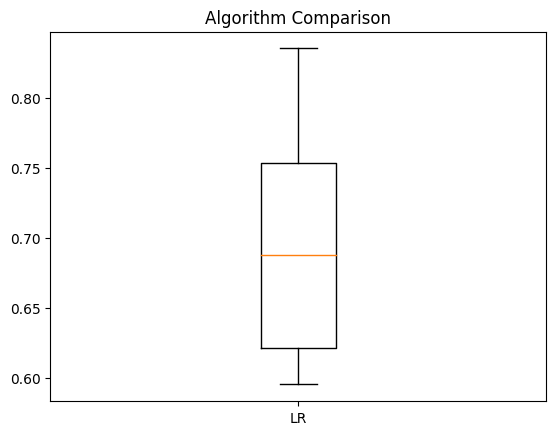

In [410]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

windall = pivwddf.join(wgalldf, how='outer')
models = []
models.append(('LR', LinearRegression()))
#models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
#models.append(('KNN', KNeighborsRegressor())) 
#models.append(('RF', RandomForestRegressor())) # Ensemble method - collection of many decision trees
#models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
#X_train = windall[inputparams]
#y_train = windall['ACTUAL WIND(MW)'].values

windall.drop('Datetime', axis=1, inplace=True)
X_train = windall[:'2021'].drop(['ACTUAL WIND(MW)'], axis = 1)
y_train = windall.loc[:'2021', 'ACTUAL WIND(MW)']
X_test = windall['2022'].drop(['ACTUAL WIND(MW)'], axis = 1)
y_test = windall.loc['2022', 'ACTUAL WIND(MW)']

results = []
names = []
for name, model in models:
   # TimeSeries Cross validation
   tscv = TimeSeriesSplit(n_splits=8)    
   cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
   results.append(cv_results)
   names.append(name)
   print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()


Grid Search


In [ ]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
#model = LinearRegression()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=8)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_


The best hyperparameters found during the grid search are:
RandomForestRegressor(max_depth=14, max_features='auto')
0.7517674776371366

In [417]:
print("The best hyperparameters found during the grid search are:")
print(best_model)
print(best_score)
#y_true = y_test.values
#y_pred = best_model.predict(X_test)
#regression_results(y_true, y_pred)

The best hyperparameters found during the grid search are:
RandomForestRegressor(max_depth=14, max_features='auto')
0.7517674776371366


Test the model with the best parameters
r2 score = 0.7439255015572916

In [433]:
from sklearn.metrics import mean_squared_error, r2_score
y_true = y_test.values
y_pred = best_model.predict(X_test)
#regression_results(y_true, y_pred)
r2f = r2_score(y_test.values, y_pred)
print(r2f)
print(X_test.shape)
print(y_test.shape)

0.7439255015572916
(8760, 23)
(8760,)


Get best features

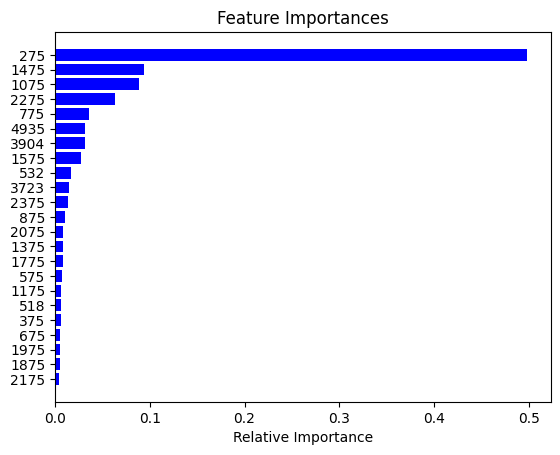

In [420]:
imp = best_model.feature_importances_
features = X_test.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Make a copy of windall, drop all but the top5 features and rerun the model

In [435]:
#windfew=windall[[275,1475,1075,2275,775]]
#windfew.head
#y_true = y_test.values
X_test2=X_test[[275,1475,1075,2275,775]]
#y_test.head
#y_pred = best_model.predict(X_test2)
#regression_results(y_true, y_pred)
regrf = RandomForestRegressor(max_depth=14, max_features='auto')
regrf.fit(X_test2, y_test.values)
y_pred=regrf.predict(X_test2)
r2f = r2_score(y_test.values, y_pred)
print(r2f)


#regrf = RandomForestRegressor()
#regrf.fit(X, y)

#preds = regr.predict(X)
#predsf = regrf.predict(X)

C:\Users\czl\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.9694440131315731


Remove all but 275

In [436]:
X_test3=X_test[[275]]
#y_test.head
#y_pred = best_model.predict(X_test2)
#regression_results(y_true, y_pred)
regrf = RandomForestRegressor(max_depth=14, max_features='auto')
regrf.fit(X_test3, y_test.values)
y_pred=regrf.predict(X_test3)
r2f = r2_score(y_test.values, y_pred)
print(r2f)

0.7314341023897568


C:\Users\czl\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Remove 775

In [438]:
X_test4=X_test[[275,1475,1075,2275,4935,3904,1575]]
#y_test.head
#y_pred = best_model.predict(X_test2)
#regression_results(y_true, y_pred)
regrf = RandomForestRegressor(max_depth=14, max_features=1.0)
regrf.fit(X_test4, y_test.values)
y_pred=regrf.predict(X_test4)
r2f = r2_score(y_test.values, y_pred)
print(r2f)

0.9592134210354805


Top 8

In [439]:
X_test5=X_test[[275,1475,1075,2275,4935,3904,1575]]
#y_test.head
#y_pred = best_model.predict(X_test2)
#regression_results(y_true, y_pred)
regrf = RandomForestRegressor(max_depth=14, max_features=1.0)
regrf.fit(X_test5, y_test.values)
y_pred=regrf.predict(X_test5)
r2f = r2_score(y_test.values, y_pred)
print(r2f)

0.9772112958195028


In [440]:
#X_test=X_test[[275,1475,1075,2275,4935,3904,1575]]
#y_test.head
#y_pred = best_model.predict(X_test2)
#regression_results(y_true, y_pred)
regrf = RandomForestRegressor(max_depth=14, max_features=1.0)
regrf.fit(X_test, y_test.values)
y_pred=regrf.predict(X_test)
r2f = r2_score(y_test.values, y_pred)
print(r2f)

0.9862874133316009


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}       
tscv = TimeSeriesSplit(n_splits=9)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(sample['ACTUAL WIND(MW)'], preds)
print("The Coefficient of determination for all features Linear Regression on test set: {:.4f}".format(r2))

r2f = r2_score(sample['ACTUAL WIND(MW)'], predsf)
print("The Coefficient of determination for all features Forest Regression on test set: {:.4f}".format(r2f))

for feature in inputparams:
    print(sample[feature])
    r2 = r2_score(sample[feature], preds)
    print("The Coefficient of determination for feature: "+str(feature)+" Linear Regression on test set: {:.4f}".format(r2))
    r2f = r2_score(sample[feature], predsf)
    print("The Coefficient of determination for feature: "+str(feature)+" Linear Regression on test set: {:.4f}".format(r2f))    

In [418]:
print("The Coefficient of determination for all features Forest Regression on test set: {:.4f}".format(r2f))

The Coefficient of determination for all features Forest Regression on test set: -63781.0203


Random Forest Regression

Splitting dataset into training sets and test sets
Couldn't split with timeseries split because of lea years
Removing


In [398]:
from sklearn.model_selection import TimeSeriesSplit
windall = pivwddf.join(wgalldf, how='outer')
#windall.to_csv('./windgeneration/windall.csv')
windall.drop('Datetime', axis=1, inplace=True)
#windall = windall[~((windall.index.month == 2) & (windall.index.day == 29))]
#windall.dtypes
trains=[]
startyear=2014
endyear=2022
#print(windall.shape)
#for year in range(2014,2023):
 #   yeardf=windall[year:]
 #   print(yeardf.shape)

year = windall.index.to_period("Y")
aggcount = windall.groupby([year]).count()
#print(aggcount)
#tscv = TimeSeriesSplit(n_splits=9)
#tscv.test_size
tscv = TimeSeriesSplit(n_splits=len(windall.index.to_period("Y").unique()) - 1)
for train_idx, test_idx in tscv.split(windall.index.to_period("Y")):
    print('TRAIN: ', windall.loc[windall.index.isin(train_idx), str(windall.index.to_period("Y"))].unique(), 
          'TEST: ', windall.loc[windall.index.isin(test_idx), str(windall.index.to_period("Y"))].unique())

#year2016=windall.loc[windall.index.to_period("Y") == '2016']
#year2016.shape
#(8784, 24)
#week = windall.index.to_period("w")
#hourcount = windall.groupby([week]).count()
#print(hourcount)
#2020,2016
#for group in agg:
#    print(group)
#for year in range(startyear,year+1):
    #yeardf=windall.loc(index.year == year)
    #yeardf.shape
    # create train test partition
    
    #train = windall[startyear:year+1]
    #test  = windall[year+1:]
    #print('Train Dataset:',train.shape)
    #print('Test Dataset:',test.shape)





#dummy data
#date_range = pd.date_range('2014-01-01 00:00:00', '2022-12-31 23:00:00', freq='H')
#df = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
#df.index = date_range  # set index
#df_missing = df.drop(df.between_time('00:12', '00:14').index)

#check for missing datetimeindex values based on reference index (with all values)
#missing_dates = date_range[~date_range.isin(windall.index)]
#missing_dates = windall[~windall.index.isin(date_range)]
#print(missing_dates)
#sample=windall
#sample['year'] = sample.index.year
#sample = sample.reset_index()
#tscv = TimeSeriesSplit(n_splits=len(sample['year'].unique()) - 1)
#for train_idx, test_idx in tscv.split(sample['year']):
#    print('TRAIN: ', sample.loc[sample.index.isin(train_idx), 'year'].unique(), 
#          'TEST: ', sample.loc[sample.index.isin(test_idx), 'year'].unique())


#years = [g for n, g in windall.groupby(pd.Grouper(key=windall.index,freq='Y'))]
#years.shape
#years.get_group("2014")
# for k, v in wddf[wddf['wddir'] == ' '].groupby((wddf['wddir'] != ' ').cumsum()):
#    print(f'[group {k}]')
#    print(v['Datetime'].min())
#    print(v['Datetime'].max())
#    print(v.count())
#    print('\n') """

KeyError: "PeriodIndex(['2014', '2014', '2014', '2014', '2014', '2014', '2014', '2014',\n             '2014', '2014',\n             ...\n             '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022',\n             '2022', '2022'],\n            dtype='period[A-DEC]', name='Datetime', length=78888)"

In [ ]:
from sklearn.linear_model import LinearRegression
#Set the Input variables
import numpy as np

windall = pivwddf.join(wgalldf, how='outer')
#windall.to_csv('./windgeneration/windall.csv')
windall.drop('Datetime', axis=1, inplace=True)


inputparams=windall.columns.values.tolist()
inputparams=inputparams[:-1]
#print(count(inputparams))
startdate=pd.to_datetime('2014-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
mask = (windall.index  >= startdate) & (windall.index < enddate)
sample = windall.loc[mask]


X = sample[inputparams]
y = sample['ACTUAL WIND(MW)'].values

regr = LinearRegression()
regr.fit(X, y)

my_rf = RandomForestRegressor()
my_rf.fit(X, co2_data.co2.values)




# fit the model


# predict on the same period
preds = my_rf.predict(X)

# plot what has been learned
plt.plot(co2_data.index, co2_data.co2.values)
plt.plot(co2_data.index, preds)

## Workings ##
Clean the data
2013 records are too incomplete, remaining records missing Wind generation data 
In python program will limit the records from 2014 on
remaining groups are small, so will set to 0

In [ ]:

def check_int(value):
    try:
        int(value)
        return np.NaN
    except ValueError:
        return value

file="./windgeneration/processed/WindGenerationROIAll.csv"
wgalldf=pd.read_csv(file)

for k, v in wgalldf[wgalldf['ACTUAL WIND(MW)'] == '-'].groupby((wgalldf['ACTUAL WIND(MW)'] != '-').cumsum()):
    print(f'[group {k}]')
    print(v['datetime'].min())
    print(v['datetime'].max())
    print(v.count())
    print('\n')

wgalldf.dtypes

#plt.plot(wgalldf['datetime'], wgalldf['ACTUAL WIND(MW)'])
#wgalldf.drop_duplicates(subset=['datetime', 'ACTUAL WIND(MW)'],inplace = True)
#wgalldf.head

#wgalldf.duplicated(subset = ['datetime', 'ACTUAL WIND(MW)'])
#wgalldf.drop_duplicates(inplace = True)
#350628

2013 records are too incomplete, remaining records missing Wind generation data 
In python program will limit the records from 2014 on
remaining groups are small, so will interpolate adjacent values

In [335]:
windall = pivwddf.join(wgalldf, how='outer')
#windall.to_csv('./windgeneration/windall.csv')
windall.drop('Datetime', axis=1, inplace=True)
inputparams=windall.columns.values.tolist()
inputparams=inputparams[:-1]
print(inputparams)
for year in range(2014,2023):
    inputquery="index == '"+str(year)+"-12-16 00:00:00' "
    #print(inputquery)
    inputlist=windall.query(inputquery)[inputparams].values.tolist()
    #print(listy)
    expected=windall.query(inputquery)['ACTUAL WIND(MW)'].values[0]
    print(expected)



[275, 375, 518, 532, 575, 675, 775, 875, 1075, 1175, 1375, 1475, 1575, 1775, 1875, 1975, 2075, 2175, 2275, 2375, 3723, 3904, 4935]
496
1235
758
551
1940
1518
2559
1027
215
